In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
alldata = pd.read_csv('../data/medications.csv')

In [9]:
#data cleaning
alldata.drop(columns=['REASONCODE', 'REASONDESCRIPTION'], inplace= True)



In [3]:
#analysis

#financial analysis
alldata['COVERAGE_RATIO'] = (alldata['PAYER_COVERAGE']/ alldata['BASE_COST'])

# alldata.head(10)

In [ ]:
#insurance coverage plot

plt.figure(figsize=(8, 5), facecolor='#FFFAF6')
ax = sns.histplot(alldata['COVERAGE_RATIO'],bins=8,color="royalblue", stat='count')
ax.set_facecolor('#FFFAF6')

plt.xlabel("Insurance Coverage (%)", fontsize=12)
plt.ylabel("Prescription Count", fontsize=12)
plt.title("Insurance Coverage Distribution", fontsize=14, fontweight="bold")

for p in ax.patches:
    height = p.get_height()
    if height > 500:  
        plt.text(p.get_x() + p.get_width() / 2, height + 1,  
                 f"{int(height)}", ha="center", fontsize=8, fontweight="light")

sns.despine()
plt.savefig('../plots/insuranceCoverage.png')
plt.show()



In [ ]:
#highest cost meds
med_lookup = alldata[['CODE', 'DESCRIPTION']].drop_duplicates(subset=['CODE'])

highcost_meds_with_names = highcost_meds.merge(med_lookup, on='CODE', how='left')

prescription_counts = alldata.groupby('CODE', as_index=False)['CODE'].size()
prescription_counts.rename(columns={'size': 'PRESCRIBED'}, inplace=True)

final_table = highcost_meds_with_names.merge(prescription_counts, on='CODE', how='left')
final_table = final_table[['DESCRIPTION', 'BASE_COST', 'PRESCRIBED']]
final_table.rename(columns={'DESCRIPTION': 'MEDICINE NAME'}, inplace=True)

final_table = final_table.sort_values(by='BASE_COST', ascending=False)

In [ ]:
#finding meds that are and aren't insured

#80% and above
insured80 = alldata[alldata['COVERAGE_RATIO']> 79][['DESCRIPTION', 'BASE_COST']].drop_duplicates()

insured80.sort_values(by = ['BASE_COST'], ascending=False)

#20% and below
insured20 = alldata[alldata['COVERAGE_RATIO']< 21][['DESCRIPTION', 'BASE_COST']].drop_duplicates()

insured20.sort_values(by = ['BASE_COST'], ascending=False)

In [ ]:
plt.figure(figsize=(8, 6))

# Strip plot for <20% coverage
sns.stripplot(x=['<20% Coverage'] * len(insured20), y=insured20['BASE_COST'], jitter=True, alpha=0.6, color='skyblue')

# Strip plot for >80% coverage
sns.stripplot(x=['>80% Coverage'] * len(insured80), y=insured80['BASE_COST'], jitter=True, alpha=0.6, color='navy')

# Labels & Formatting
plt.title('Base Cost of Medicines by Coverage Ratio')
plt.xlabel('Coverage Group')
plt.ylabel('Base Cost')
plt.yscale('log')  

plt.savefig('../plots/costVscoverage.png')
plt.show()


In [ ]:
#single patient behaviour
patientID = '7e65bfa0-5e3b-3515-52aa-bfdef74ffd71'
patientData = alldata[alldata['PATIENT'] == patientID]

patientData

patientData['START'] = pd.to_datetime(patientData['START'])

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(patientData['START'], patientData['COVERAGE_RATIO'], marker='o', linestyle='-', color='b', markersize=6)

# Formatting the x-axis for better date readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format dates as Year
plt.gcf().autofmt_xdate()  

# Adding labels and title
plt.title(f"Medication Coverage Over Time for Patient {patientID}", fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Insurance Coverage Ratio (%)", fontsize=12)

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.savefig('../plots/patient1Behaviour.png')
plt.show()

In [ ]:
#rolling average plots
#all time data
alldata['START'] = pd.to_datetime(alldata['START'])
alldata = alldata.sort_values(by='START')

window = '365D'
rolling_avg = alldata.groupby('START')['COVERAGE_RATIO'].mean().rolling(window = window, min_periods=1).mean()
rolling_med = alldata.groupby('START')['COVERAGE_RATIO'].median().rolling(window = window, min_periods =1).median() 

#after 2000
filterdata = alldata[alldata['START'].dt.year >=2000]
rolling_avg_2k = filterdata.groupby('START')['COVERAGE_RATIO'].mean().rolling(window = window, min_periods=1).mean()
rolling_med_2k = filterdata.groupby('START')['COVERAGE_RATIO'].median().rolling(window = window, min_periods=1).median()

# plt.figure(figsize=(20, 12))
# plt.plot(rolling_med, color = 'red', label = "Rolling Median", alpha = 0.5)
# plt.plot(rolling_avg, color='b', label="Rolling Avg (per year)", alpha = 0.8)

# plt.xlabel("Time")
# plt.ylabel("Avg Coverage Ratio")
# plt.title("Rolling Average of Coverage Ratio Across All Time")
# plt.legend()
# plt.grid(True)
# plt.show()
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True) 
axes[0].plot(rolling_med, color='red', label="Rolling Median", alpha=0.5)
axes[0].plot(rolling_avg, color='b', label="Rolling Avg (per year)", alpha=0.8)
axes[0].set_title("Rolling Average of Coverage Ratio (All Time)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Avg Coverage Ratio")
axes[0].legend()
axes[0].grid(True)

# Plot for filtered data (post-2000)
axes[1].plot(rolling_med_2k, color='red', label="Rolling Median", alpha=0.5)
axes[1].plot(rolling_avg_2k, color='b', label="Rolling Avg (Per year)", alpha=0.8)
axes[1].set_title("Rolling Average of Coverage Ratio (From 2000 Onwards)")
axes[1].set_xlabel("Time")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('../plots/rolling_avg.png')
plt.show()

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Ensure START is datetime
alldata['START'] = pd.to_datetime(alldata['START'])

# Filter data for records from 2000 onwards
filterdata = alldata[alldata['START'].dt.year >= 2000]

# Compute rolling averages and medians
rolling_avg = alldata.groupby('START')['COVERAGE_RATIO'].mean().rolling(window=window, min_periods=1).mean()
rolling_med = alldata.groupby('START')['COVERAGE_RATIO'].median().rolling(window=window, min_periods=1).median()

rolling_avg_2k = filterdata.groupby('START')['COVERAGE_RATIO'].mean().rolling(window=window, min_periods=1).mean()
rolling_med_2k = filterdata.groupby('START')['COVERAGE_RATIO'].median().rolling(window=window, min_periods=1).median()

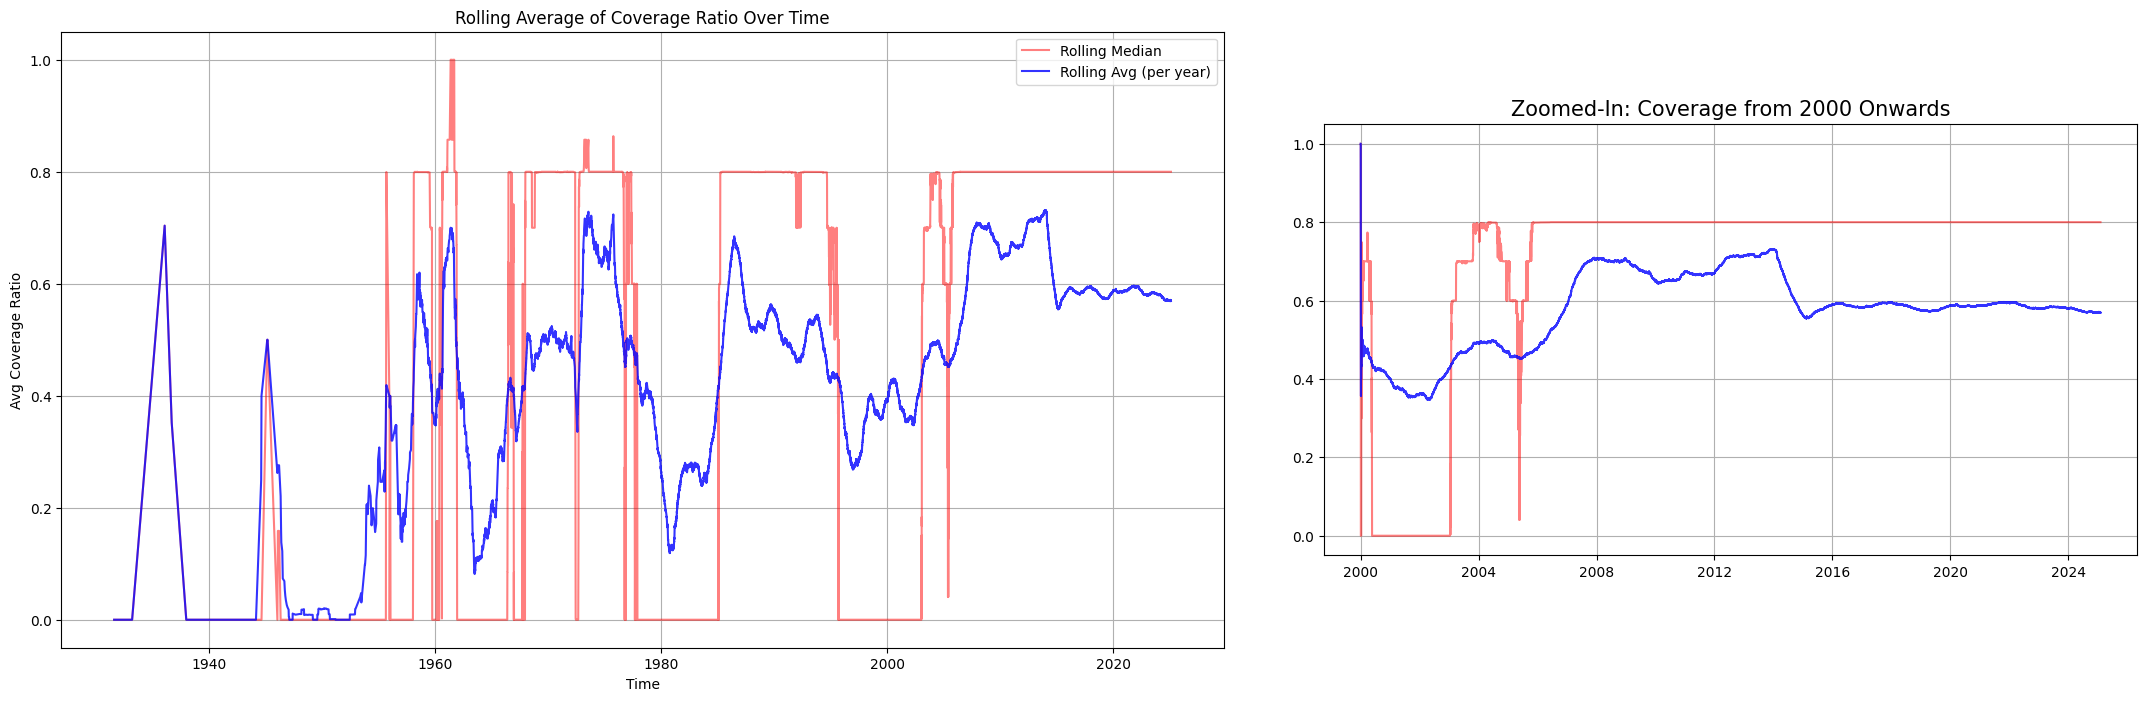

In [40]:
# Create main figure
fig, ax = plt.subplots(figsize=(15, 8))

# Plot full dataset rolling avg & median
ax.plot(rolling_med, color='red', label="Rolling Median", alpha=0.5)
ax.plot(rolling_avg, color='b', label="Rolling Avg (per year)", alpha=0.8)
ax.set_title("Rolling Average of Coverage Ratio Over Time")
ax.set_xlabel("Time")
ax.set_ylabel("Avg Coverage Ratio")
ax.legend()
ax.grid(True)

# Create inset axes for zoomed-in post-2000 view, positioned outside the main plot
ax_inset = inset_axes(ax, width="100%", height="100%", loc="center left", bbox_to_anchor=(1.08,.15, 0.7, 0.7), bbox_transform=ax.transAxes)

# Plot only the post-2000 rolling avg & median on the inset
ax_inset.plot(rolling_med_2k, color='red', alpha=0.5)
ax_inset.plot(rolling_avg_2k, color='b', alpha=0.8)

# Format inset
ax_inset.set_title("Zoomed-In: Coverage from 2000 Onwards", fontsize=15)
ax_inset.grid(True)

# Show the plot
plt.savefig('../plots/rollingavgZoom.png')
plt.show()
